## Introduction

In this notebook, I will be using Regression models to predict value of homes. The task is supervised - we are given labeled training data to fit our model - and it is a regression task because the lables are continous. We are predicting the Median value of owner-occupied homes in $1000's

## Problem statement

We are predicting the median value of owner-occupied homes in $1000.  We have 13 continuous features. The dataset is a real-world data gotten from the StatLib library which is maintained at Carnegie Mellon University.

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Reading data

In [2]:
data=pd.read_csv('data.csv')

In [3]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
data.shape

(511, 14)

## check  for missing data

In [5]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         5
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [6]:
data=data.dropna()

## data visualization 

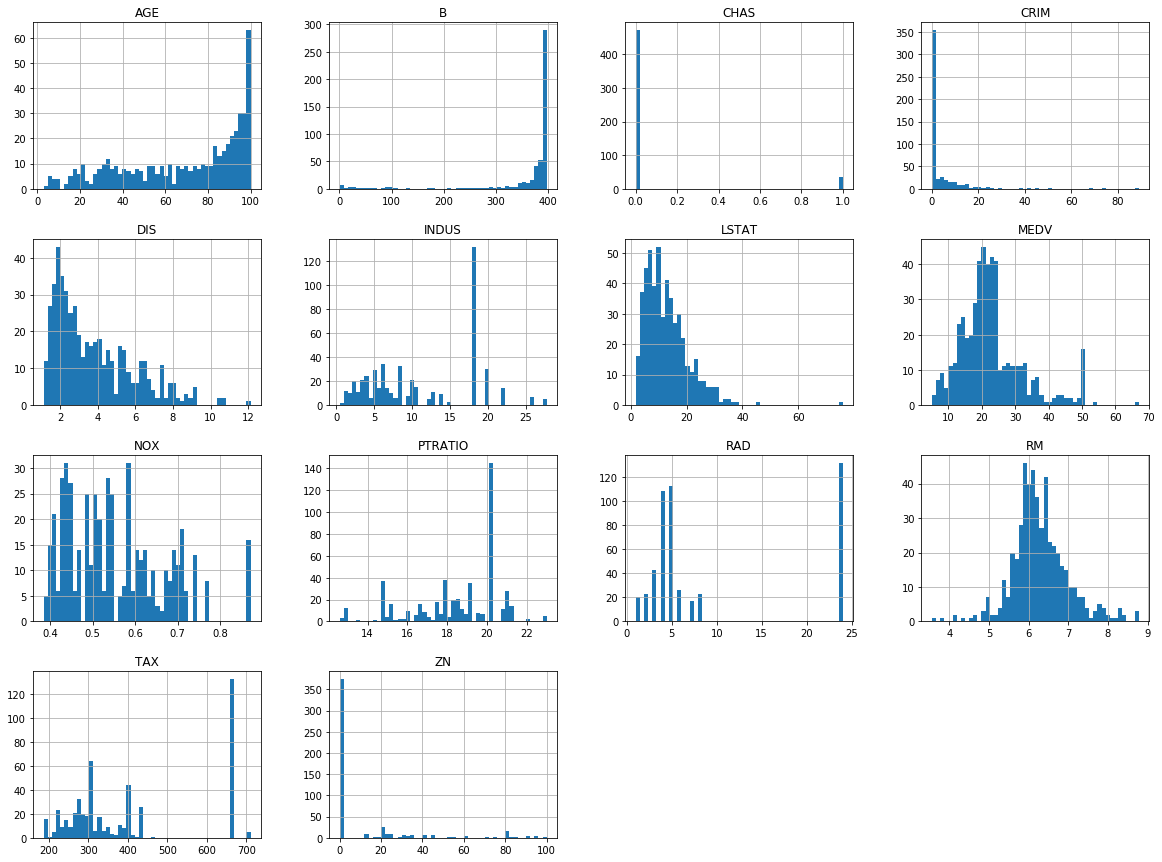

In [7]:
data.hist(bins=50, figsize=(20, 15))
plt.show()

According to the histogram. most of the data are skewed.
let's log transform them

In [8]:
log_col = ['CRIM', 'NOX', 'DIS', 'LSTAT']

In [9]:
for feat in log_col:
    data['LOG_'+feat]=np.log(data[[feat, ]])

In [10]:
data.drop(log_col, axis=1, inplace=True)

let's arrange their ages into a smaller number of age intervals

In [11]:
data['AGE_CUT'] = pd.cut(data['AGE'],bins=[0,25.0 ,50.0 ,75.0  ,100.0 ,np.inf],labels=[1,2,3,4,5])

In [12]:
data.shape

(506, 15)

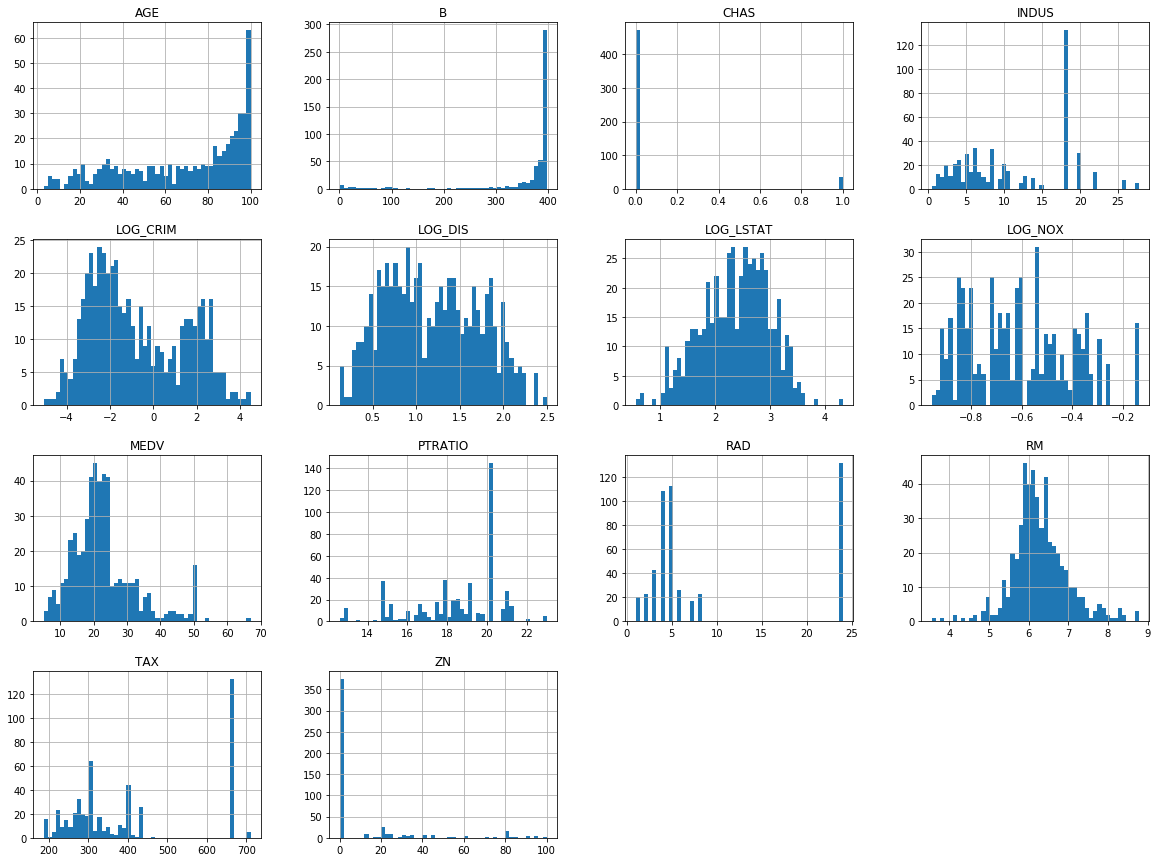

In [13]:
data.hist(bins=50, figsize=(20, 15))
plt.show()

## checking for correlations

In [14]:
corr_matrix = data.corr()
corr_matrix['MEDV'].sort_values(ascending=False)

MEDV         1.000000
RM           0.667695
ZN           0.339327
B            0.319851
LOG_DIS      0.279463
CHAS         0.164175
AGE         -0.366717
RAD         -0.382068
LOG_NOX     -0.414457
LOG_CRIM    -0.439553
PTRATIO     -0.451117
TAX         -0.461959
INDUS       -0.466094
LOG_LSTAT   -0.732277
Name: MEDV, dtype: float64

Rm  and Lstat has high correlaations with Medv

In [15]:
corr_matrix

,ZN,INDUS,CHAS,RM,AGE,RAD,TAX,PTRATIO,B,MEDV,LOG_CRIM,LOG_NOX,LOG_DIS,LOG_LSTAT
ZN,1.000000,-0.536888,-0.041824,0.307812,-0.567952,-0.309652,-0.312901,-0.394101,0.176625,0.339327,-0.518700,-0.570194,0.592102,-0.476598
INDUS,-0.536888,1.000000,0.061746,-0.392193,0.644182,0.594344,0.718784,0.378739,-0.357787,-0.466094,0.731303,0.779443,-0.762026,0.592158
CHAS,-0.041824,0.061746,1.000000,0.089952,0.086664,-0.006803,-0.035770,-0.124780,0.050143,0.164175,0.027068,0.081730,-0.085063,-0.076413
RM,0.307812,-0.392193,0.089952,1.000000,-0.237335,-0.213078,-0.293969,-0.339755,0.127888,0.667695,-0.306748,-0.303604,0.252349,-0.647223
AGE,-0.567952,0.644182,0.086664,-0.237335,1.000000,0.456212,0.505186,0.261170,-0.273739,-0.366717,0.657852,0.764641,-0.779027,0.587553
RAD,-0.309652,0.594344,-0.006803,-0.213078,0.456212,1.000000,0.910898,0.441336,-0.441338,-0.382068,0.850577,0.623151,-0.557756,0.441893
TAX,-0.312901,0.718784,-0.035770,-0.293969,0.505186,0.910898,1.000000,0.442510,-0.439917,-0.461959,0.826064,0.675883,-0.615545,0.506976
PTRATIO,-0.394101,0.378739,-0.124780,-0.339755,0.261170,0.441336,0.442510,1.000000,-0.176542,-0.451117,0.384941,0.228689,-0.239420,0.437964
B,0.176625,-0.357787,0.050143,0.127888,-0.273739,-0.441338,-0.439917,-0.176542,1.000000,0.319851,-0.477505,-0.379053,0.324109,-0.340087
MEDV,0.339327,-0.466094,0.164175,0.667695,-0.366717,-0.382068,-0.461959,-0.451117,0.319851,1.000000,-0.439553,-0.414457,0.279463,-0.732277


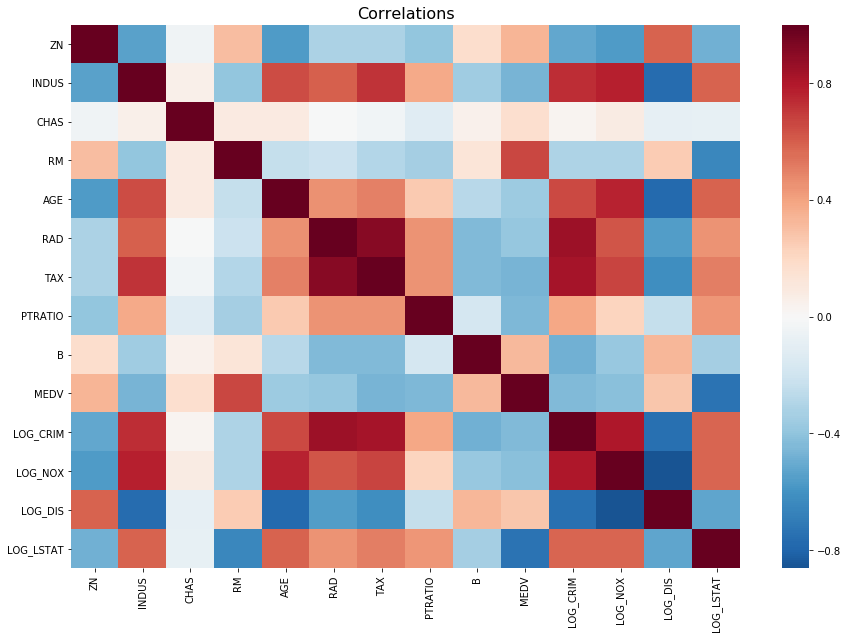

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0.0) 
plt.title('Correlations',fontsize=16)
plt.show()

BASE MODELS

LINEAR REGRESSION,LASSO REGRESSION, RIDGE REGRESSION , SUPPORT VECTOR MACHINE REGRESSION.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [18]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('reg', LinearRegression())])
pipe_lasso = Pipeline([('scl', StandardScaler()),
                    ('reg', Lasso())])
pipe_ridge = Pipeline([('scl', StandardScaler()),
                    ('reg', Ridge())])

pipe_svr = Pipeline([('scl', StandardScaler()),
                     ('reg', SVR())])

In [19]:
X=data.drop('MEDV', axis=1)

In [20]:
y=data['MEDV']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [22]:
pipelines = [pipe_lr, pipe_lasso,pipe_ridge, pipe_svr]

In [23]:
pipe_dict = {0: 'Linear Regression', 1: 'Lasso Regression', 2: 'Ridge Regression', 3:'Support Vector Regression'}


In [24]:
for pipe in pipelines:
	pipe.fit(X_train, y_train)

In [25]:
for idx, val in enumerate(pipelines):
    pred = val.predict(X_test)
    print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], np.sqrt(mean_squared_error(y_test, pred))))

Linear Regression pipeline test accuracy: 4.292
Lasso Regression pipeline test accuracy: 4.850
Ridge Regression pipeline test accuracy: 4.290
Support Vector Regression pipeline test accuracy: 4.621


Choosing the top three models for hyperparameter tuning

RIDGE

In [26]:
model = Ridge()

In [27]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [28]:
grid = dict()
grid['alpha'] = np.arange(0, 10, 0.01)

In [29]:
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -3.480
Config: {'alpha': 1.71}


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


LINEAR REGRESSION

In [30]:
model2=LinearRegression()

In [31]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [32]:
c_space = np.logspace(-5, 8, 15) 
param = {'n_jobs': c_space} 

In [33]:
search = GridSearchCV(model2, param, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -3.486
Config: {'n_jobs': 1e-05}


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVR

In [34]:
svr = SVR(kernel='rbf')

In [35]:
c=np.arange(50, 101, 10)

In [36]:
gamma=np.arange(0.01,0.11, 0.01)

In [37]:
epsilon= np.arange(0.1, 10, 1)

In [38]:
gamma

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [39]:
par ={'C': c, 'gamma': gamma, 'epsilon':epsilon}

In [40]:
search = GridSearchCV(svr, par, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -5.028
Config: {'C': 80, 'epsilon': 1.1, 'gamma': 0.01}


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Going for the lowest neg_mean_absolute_error . Svr is the choosen model.

## Training... before feature importance

In [41]:
X=data.drop(['AGE','MEDV', 'ZN'], axis=1)

In [42]:
y=data['MEDV']

In [43]:
pipelin=Pipeline([
    ('std_scaler', StandardScaler())
])
X_transformed=pipelin.fit_transform(X)

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_transformed, y, test_size=0.3, random_state=42)

In [45]:
svr2=SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.9)

In [46]:
svr2.fit(X_train, y_train)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.9, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [47]:
pred=svr2.predict(X_test)

In [48]:
final_mse=mean_squared_error(y_test,pred)
final_rmse=np.sqrt(final_mse)

In [49]:
final_rmse

2.941466730130906

## Feature_importance using Linear regression

In [50]:
model3=LinearRegression()

In [51]:
model3.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
importance = model3.coef_

In [53]:
col=[]
score=[]
for i,v in enumerate(importance):
    col.append( data.columns[i])
    score.append(v)
feat_impo= {
    'col':col,
    'score':score
}
df = pd.DataFrame(feat_impo, columns = ['col', 'score'])
df

,col,score
0,ZN,-0.215417
1,INDUS,0.546743
2,CHAS,3.535126
3,RM,0.301533
4,AGE,-1.916053
5,RAD,-0.703617
6,TAX,1.105029
7,PTRATIO,0.750073
8,B,-1.924189
9,MEDV,-3.679906


In [54]:
df.sort_values(by=['score'])

,col,score
10,LOG_CRIM,-3.706037
9,MEDV,-3.679906
8,B,-1.924189
4,AGE,-1.916053
11,LOG_NOX,-0.815431
5,RAD,-0.703617
0,ZN,-0.215417
3,RM,0.301533
1,INDUS,0.546743
7,PTRATIO,0.750073


In [55]:
#no of features
from sklearn.feature_selection import RFE
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 5
Score with 5 features: 0.637864


In [57]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 5)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['CHAS', 'RM', 'LOG_NOX', 'LOG_DIS', 'LOG_LSTAT'], dtype='object')


## Training after feature selection

Droping the rest of the features and training with only five features

In [58]:
X1=data.drop(['AGE','MEDV', 'ZN','INDUS', 'B','RAD','PTRATIO','LOG_CRIM','AGE_CUT','TAX'], axis=1)

In [59]:
y=data['MEDV']

In [60]:
pipelin=Pipeline([
    ('std_scaler', StandardScaler())
])
X_transformed=pipelin.fit_transform(X1)

In [61]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y_train, y_test=train_test_split(X_transformed, y, test_size=0.3, random_state=42)

In [62]:
svr3=SVR(kernel='rbf', C=100, gamma=0.1)

In [63]:
svr3.fit(X_train, y_train)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [64]:
final_mse=mean_squared_error(y_test,pred)
final_rme=np.sqrt(final_mse)

In [65]:
final_rme

2.941466730130906

In [67]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))